###Importation des librairies

In [203]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from glob import glob
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import sys , os , collections ,random , re , json , time , pickle , datetime

###Configuration GPU

In [204]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [205]:
# chemin du ficher json contenant les annotations
annotation_folder = "/annotations/"
annotation_file = os.path.abspath(".")+"/annotations/captions_train2014.json"

In [206]:
# chemin du dossier contenant les images a annoter
image_folder = "/train2014/"
PATH = os.path.abspath(".")+ image_folder

In [207]:
# lecture du fichier d'annotations
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [208]:
# grouper les annotations ayant le meme identifiant d'image
image_path_to_caption = collections.defaultdict(list)

for val in annotations['annotations']:
    # on ajoute le token <start> et <end> au debut et a la fin de la phrase
    caption = f"<start> {val['caption']} <end>"
    # on recupere le chemin de l'image
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # on ajoute la phrase a la liste des phrases de l'image
    image_path_to_caption[image_path].append(caption)

# on recupere les chemins des images
image_paths = list(image_path_to_caption.keys())

# on recupere les phrases
# captions = list(image_path_to_caption.values())

# prendre les 3000 premiers chemins d'images
train_image_paths = image_paths[:3000]

# liste de toutes les annotations
train_captions = []
# liste de tout les noms de fichiers des images dupliqués ('en nombre d'anotations par image')
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # on ajoute les phrases a la liste des phrases
    train_captions.extend(caption_list)
    # on ajoute le nom de l'image autant de fois qu'il y a d'annotations
    img_name_vector.extend([image_path] * len(caption_list))

In [209]:
# telecharger le modele InceptionV3
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

In [210]:
# creation d'une variable qui sera l'entree du modele de pre traitement des images
new_input = image_model.input
# creation d'une variable qui sera la sortie du modele de pre traitement des images (contient les features)
hidden_layer = image_model.layers[-1].output

# creation du modele de pre traitement des images qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# fonction qui calcule les features d'une image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [211]:
# pretraitements des images

# recuperer les noms des images
encode_train = sorted(set(img_name_vector))

# creation d'un dictionnaire qui associe a chaque nom d'image son chemin
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Diviser le dataset en batch de 16 images apres application du pretraitement fait par la fonction load_image
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# calculer les features de chaque image
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    # sauvegarder les features dans un fichier .npy
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 188/188 [00:49<00:00,  3.80it/s]


In [212]:
# Trouver la taille maximale
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


# choisir les 5000 images les plus frequemment annotées du dataset
top_k = 5000
# la classe Tokenizer permet de creer un dictionnaire qui associe a chaque mot un entier
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,/:;=?@[\]^_`{|}~ ')

# construire le dictionnaire en se basant sur les phrases du dataset de train_captions
tokenizer.fit_on_texts(train_captions)

# creer un dictionnaire qui associe a chaque entier son mot
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# creation des vecteurs de phrases a partir des phrases du dataset
train_seqs = tokenizer.texts_to_sequences(train_captions)

# remplissage des vecteurs de phrases pour qu'ils aient tous la meme taille
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# calcul de la taille maximale des phrases
max_length = calc_max_length(train_seqs)

print("max_length = ", max_length)

max_length =  33


In [213]:
# formation du jeu d'entrainement et de test
img_to_cap_vector = collections.defaultdict(list)

# creation d'un dictionnaire qui associe a chaque image son vecteur de phrases
print("img_name_vector = ", len(img_name_vector))
print("cap_vector = ", len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# creation des listes d'images et de phrases
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# construction des listes d'images et de phrases pour l'entrainement
img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# construction des listes d'images et de phrases pour le test
img_name_val = []
cap_val = []

for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

print("img_name_train = ", len(img_name_train))
print("cap_train = ", len(cap_train))
print("img_name_val = ", len(img_name_val))
print("cap_val = ", len(cap_val))

img_name_vector =  15007
cap_vector =  15007
img_name_train =  12005
cap_train =  12005
img_name_val =  3002
cap_val =  3002


In [214]:
BATCH_SIZE = 64 # taille des batchs
BUFFER_SIZE = 1000 # taille du buffer
embedding_dim = 256 # dimension de l'espace de representation des mots
units = 512 # nombre de neurones de la couche LSTM
vocab_size = top_k + 1 # taille du dictionnaire
num_steps = len(img_name_train) // BATCH_SIZE # nombre de batchs par epoch
features_shape = 2048 # dimension de l'espace de representation des images
attention_features_shape = 64 # dimension de l'espace de representation des features d'attention

In [215]:
# function qui charge les features d'une image
def map_func(img_name, cap):
    # charger les features de l'image
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


# creation du dataset d'entrainement
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# charger les features des images
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# melanger les donnees
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [216]:
class CNN_ENCODER(tf.keras.Model):  # classe qui permet d'extraire les features d'une image
    def __init__(self, embedding_dim):
        super(CNN_ENCODER, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # extraction des features de l'image
        x = self.fc(x)
        x = tf.nn.relu(x)

        return x


In [217]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [218]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [219]:
encoder = CNN_ENCODER(embedding_dim)

decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [220]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [221]:
checkpoint_path = "./checkpoints/train" + f"_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [222]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [223]:
loss_plot = []


@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


Epoch 1 Batch 0 Loss 3.0278
Epoch 1 Batch 100 Loss 1.6529
Epoch 1 Loss 1.637137
Time taken for 1 epoch 73.76394772529602 sec
Epoch 2 Batch 0 Loss 1.5269
Epoch 2 Batch 100 Loss 1.1734
Epoch 2 Loss 1.299045
Time taken for 1 epoch 21.86396288871765 sec
Epoch 3 Batch 0 Loss 1.2986
Epoch 3 Batch 100 Loss 1.1573
Epoch 3 Loss 1.160836
Time taken for 1 epoch 21.570138454437256 sec
Epoch 4 Batch 0 Loss 1.2621
Epoch 4 Batch 100 Loss 1.0812
Epoch 4 Loss 1.067271
Time taken for 1 epoch 22.192615270614624 sec
Epoch 5 Batch 0 Loss 1.0324
Epoch 5 Batch 100 Loss 0.9854
Epoch 5 Loss 0.996177
Time taken for 1 epoch 22.291810274124146 sec
Epoch 6 Batch 0 Loss 0.9821
Epoch 6 Batch 100 Loss 0.9405
Epoch 6 Loss 0.933353
Time taken for 1 epoch 21.958847284317017 sec
Epoch 7 Batch 0 Loss 0.8789
Epoch 7 Batch 100 Loss 0.8962
Epoch 7 Loss 0.878220
Time taken for 1 epoch 22.17119288444519 sec
Epoch 8 Batch 0 Loss 0.8639
Epoch 8 Batch 100 Loss 0.8126
Epoch 8 Loss 0.828351
Time taken for 1 epoch 22.3215069770813 s

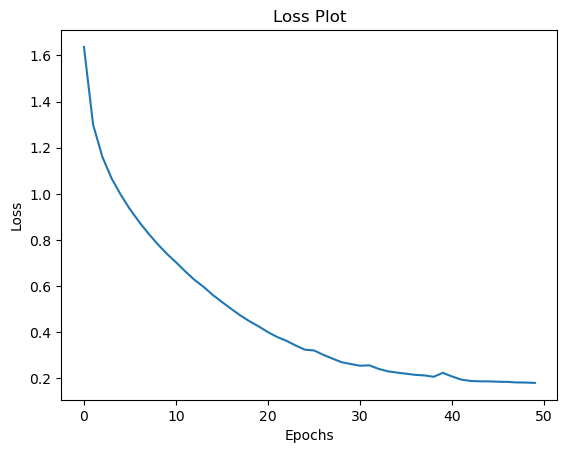

In [224]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
        ckpt_manager.save()
    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss / num_steps))
    print('Time taken for 1 epoch {} sec'.format(time.time() - start))

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [225]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [226]:
def plot_attention(image , result , attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a bathroom with a tub sink and white toilet <end>
Prediction Caption: the bathroom has a toilet next to a bath tub <end>


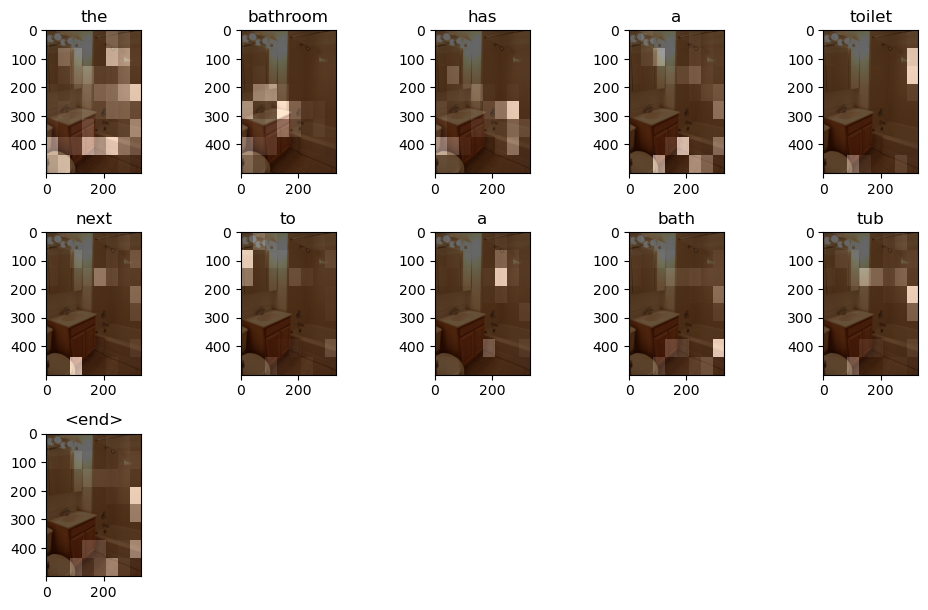

In [236]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: a guy on a skatepark <end>


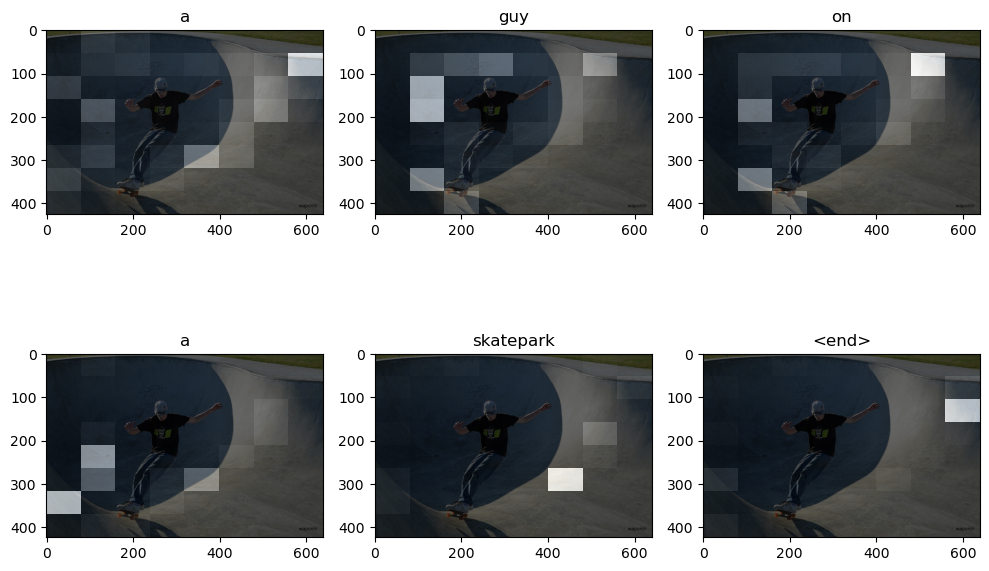

In [243]:
test_folder = './test/Dataset'

test_images = os.listdir(test_folder)

test_images = [os.path.join(test_folder, image) for image in test_images]

rid = np.random.randint(0, len(test_images))

image = test_images[rid]

result, attention_plot = evaluate(image)

print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)